In [1]:
import numpy as np
import csv
from math import lgamma
import pandas as pd
import matplotlib.pyplot as plt
import os

## Read data

In [2]:
## Data file should be strings of 0s and 1s without spacing
def read_data(filename):
    Kset = {}
    N = 0
    with open(filename, 'r') as file:
        for line in file.readlines():
            #print(line)
            s = int(line[:n],2)
            N += 1
            if s in Kset:
                Kset[s] += 1
            else:
                Kset[s] = 1
    return Kset, N


In [3]:
def channel_order(filename, channel, number):
    ##reads data, and puts it in order of channels
    ## returns the correct channel and id order, with the Kset and N
    data_strings = np.loadtxt(filename, dtype=str) #load data
    N = data_strings.shape[0]
    data_num = np.zeros((n,N))
    for i,data_string in enumerate(data_strings):
        data_num[:,i] = np.array([int(c) for c in data_string]) 
    
    index_order = np.argsort(channel)
    #order channel, id and dataset
    channel = channel[index_order]
    number = number[index_order]
    data_num = data_num[index_order,:]
    
    #reverse columns of dataset
    data_num = np.fliplr(data_num)
    
    #reverse data_num to strings
    data_df = np.transpose(data_num)
    data_df = pd.DataFrame(data_df)
    data_strings = data_df.astype('int').astype('str')
    data_strings = pd.Series(data_strings.fillna('').values.tolist()).str.join('')
    
    Kset = {}
    N = 0
    for line in data_strings:
        #print(line)
        s = int(line[:n],2)
        N += 1
        if s in Kset:
            Kset[s] += 1
        else:
            Kset[s] = 1
    return Kset, N, channel, number

In [4]:
def print_partition(MCM):
    for com,ICC in MCM.items():
        binary = bin(ICC).replace("0b", "")
        missing = n - len(binary)
        print(f'com {com}\t' + '0'*missing + binary)

def get_partition(MCM, i):
    binary = bin(MCM[i]).replace("0b", "")
    missing = n - len(binary)
    binary = '0'*missing + binary
    data = np.array([int(c) for c in binary])
    return data

## Calculate log evidence

In [5]:
def complexity(m):
    power = 1 << (m-1)
    return np.log(np.pi) * power - np.math.lgamma(power)

def project_icc(Kset, ICC):
    new_Kset = {}
    for s,ks in Kset.items():
        s_new = s & ICC
        if s_new in new_Kset:
            new_Kset[s_new] += ks
        else:
            new_Kset[s_new] = ks
    return new_Kset, bin(ICC).count("1")

def log_evidence_ICC(Kset, ICC):
    LogE = 0
    new_Kset, nNode = project_icc(Kset, ICC)
    for s,ks in new_Kset.items():
        LogE += np.math.lgamma(ks + 0.5)
    LogE -= (complexity(nNode) + np.math.lgamma(N + (1 << (nNode - 1))))
    return LogE

def log_evidence_MCM(Kset, MCM):
    LogE = 0
    for _,ICC in MCM.items():
        LogE += log_evidence_ICC(Kset, ICC)
    return LogE

## Hierarchical merging

In [6]:
def merging(Kset):
    MCM = {}
    logE_MCM = {}
    
    for i in range(n):
        MCM[i] = (1 << i)
        logE_MCM[i] = log_evidence_ICC(Kset, MCM[i])
    
    logE_mat = np.zeros((n,n))
    
    stop = False
    
    while not stop and len(MCM)-1:
        best_diff = 0
        for i,node1 in MCM.items():
            for j,node2 in MCM.items():
                if i>=j:
                    continue

                if not logE_mat[i,j]:
                    logE_mat[i,j] = log_evidence_ICC(Kset, node1 + node2)
                    logE_mat[j,i] = logE_mat[i,j]
                
                if logE_mat[i,j] - logE_MCM[i] - logE_MCM[j] > best_diff:
                    best_diff = logE_mat[i,j] - logE_MCM[i] - logE_MCM[j]
                    best_merger = [[i,node1], [j,node2]]
                    
        if best_diff == 0:
            stop = True
            continue
        
        i_keep = best_merger[0][0]; node_keep = best_merger[0][1]
        i_erase = best_merger[1][0]; node_erase = best_merger[1][1]
                
        logE_MCM[i_keep] = logE_mat[i_keep, i_erase] 
        MCM[i_keep] = node_keep + node_erase
        
        logE_MCM.pop(i_erase)
        MCM.pop(i_erase)
        
        logE_mat[i_keep,:] = 0
        logE_mat[:,i_keep] = 0
        
    return MCM, sum([items for _,items in logE_MCM.items()])

## Measures

In [7]:
def norm_mut_info(MCM1, MCM2):
    I = 0
    H = 0
    flag = 0
    for _,ICC1 in MCM1.items():
        p1 = bin(ICC1).count("1") / n
        for _,ICC2 in MCM2.items():
            p2 = bin(ICC2).count("1") / n
            p12 = bin(ICC1 & ICC2).count("1") / n
            if p12:
                I += p12 * np.log(p12/(p1*p2))
            if flag < len(MCM2):
                H += p2 * np.log(p2)
                flag += 1
        H += p1 * np.log(p1)
    
    if not H:
        return 1
    else:
        return -2*I/H

In [8]:
def var_of_info(MCM1, MCM2):
    I = 0
    H = 0
    for _,ICC1 in MCM1.items():
        p1 = bin(ICC1).count("1") / n
        for _,ICC2 in MCM2.items():
            p2 = bin(ICC2).count("1") / n
            p12 = bin(ICC1 & ICC2).count("1") / n
            if p12:
                I += p12 * np.log(p12/(p1*p2))
                H += p12 * np.log(p12)
    
    if not H:
        return 0
    else:
        return 1 + I/H

## Tests

In [9]:
##get files/paths
##get all files
dates = ["20190904", "20190828", "20190409", "20190125", "20180807", "20180727"]
files = os.listdir("C:/Users/marij/Documents/studie/CLS/Masterproject/data_processing/data_binarization") #kilosort output folder

#print(files)
file_list = []

for i in dates: #extract wanted files out of the folder
    file_list.append([file for file in files if i in file])
    
file_list = np.array(file_list).flatten()
print(file_list)

bins = [str(1), str(5), str(10), str(15), str(20), str(30), str(40), str(50)]

folder_path = "C:/Users/marij/Documents/studie/CLS/Masterproject/data_processing/data_binarization/"
save_path = savepath = 'C:/Users/marij/Documents/studie/CLS/Masterproject/RESULTS/MCM/whole_dataset/'
save_path2 = 'C:/Users/marij/Documents/studie/CLS/Masterproject/RESULTS/bin_organized/'

#file_list = file_list[[11]]
#print(file_list)
#bins = [str(50)]


['20190904_RippleF2_spk2_d02.dat' '20190904_Vocalization_spk2_d02.dat'
 '20190828_RippleF2_d02.dat' '20190828_Vocalization_d02.dat'
 '20190409_Ripple2_d01.dat' '20190409_Vocalization_d01.dat'
 '20190125_Ripple2_d01.dat' '20190125_Vocalization_d01.dat'
 '20180807_Ripple2_d01.dat' '20180807_Vocalization_d01.dat'
 '20180727_Ripple2_d01.dat' '20180727_Vocalization_d01.dat']


n =  16
file:  20190904_RippleF2_spk2_d02.dat
bin:  1


<ipython-input-10-0c8a59a47d27>:97: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


file:  20190904_RippleF2_spk2_d02.dat
bin:  5
file:  20190904_RippleF2_spk2_d02.dat
bin:  10
file:  20190904_RippleF2_spk2_d02.dat
bin:  15
file:  20190904_RippleF2_spk2_d02.dat
bin:  20
file:  20190904_RippleF2_spk2_d02.dat
bin:  30
file:  20190904_RippleF2_spk2_d02.dat
bin:  40
file:  20190904_RippleF2_spk2_d02.dat
bin:  50


<ipython-input-10-0c8a59a47d27>:121: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figs.show()


n =  17
file:  20190904_Vocalization_spk2_d02.dat
bin:  1
file:  20190904_Vocalization_spk2_d02.dat
bin:  5
file:  20190904_Vocalization_spk2_d02.dat
bin:  10
file:  20190904_Vocalization_spk2_d02.dat
bin:  15
file:  20190904_Vocalization_spk2_d02.dat
bin:  20
file:  20190904_Vocalization_spk2_d02.dat
bin:  30
file:  20190904_Vocalization_spk2_d02.dat
bin:  40
file:  20190904_Vocalization_spk2_d02.dat
bin:  50
n =  18
file:  20190828_RippleF2_d02.dat
bin:  1
file:  20190828_RippleF2_d02.dat
bin:  5


<ipython-input-10-0c8a59a47d27>:79: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1)


file:  20190828_RippleF2_d02.dat
bin:  10
file:  20190828_RippleF2_d02.dat
bin:  15
file:  20190828_RippleF2_d02.dat
bin:  20
file:  20190828_RippleF2_d02.dat
bin:  30
file:  20190828_RippleF2_d02.dat
bin:  40
file:  20190828_RippleF2_d02.dat
bin:  50
n =  16
file:  20190828_Vocalization_d02.dat
bin:  1
file:  20190828_Vocalization_d02.dat
bin:  5
file:  20190828_Vocalization_d02.dat
bin:  10
file:  20190828_Vocalization_d02.dat
bin:  15
file:  20190828_Vocalization_d02.dat
bin:  20
file:  20190828_Vocalization_d02.dat
bin:  30
file:  20190828_Vocalization_d02.dat
bin:  40
file:  20190828_Vocalization_d02.dat
bin:  50
n =  17
file:  20190409_Ripple2_d01.dat
bin:  1
file:  20190409_Ripple2_d01.dat
bin:  5
file:  20190409_Ripple2_d01.dat
bin:  10
file:  20190409_Ripple2_d01.dat
bin:  15
file:  20190409_Ripple2_d01.dat
bin:  20
file:  20190409_Ripple2_d01.dat
bin:  30
file:  20190409_Ripple2_d01.dat
bin:  40
file:  20190409_Ripple2_d01.dat
bin:  50
n =  18
file:  20190409_Vocalization_d01

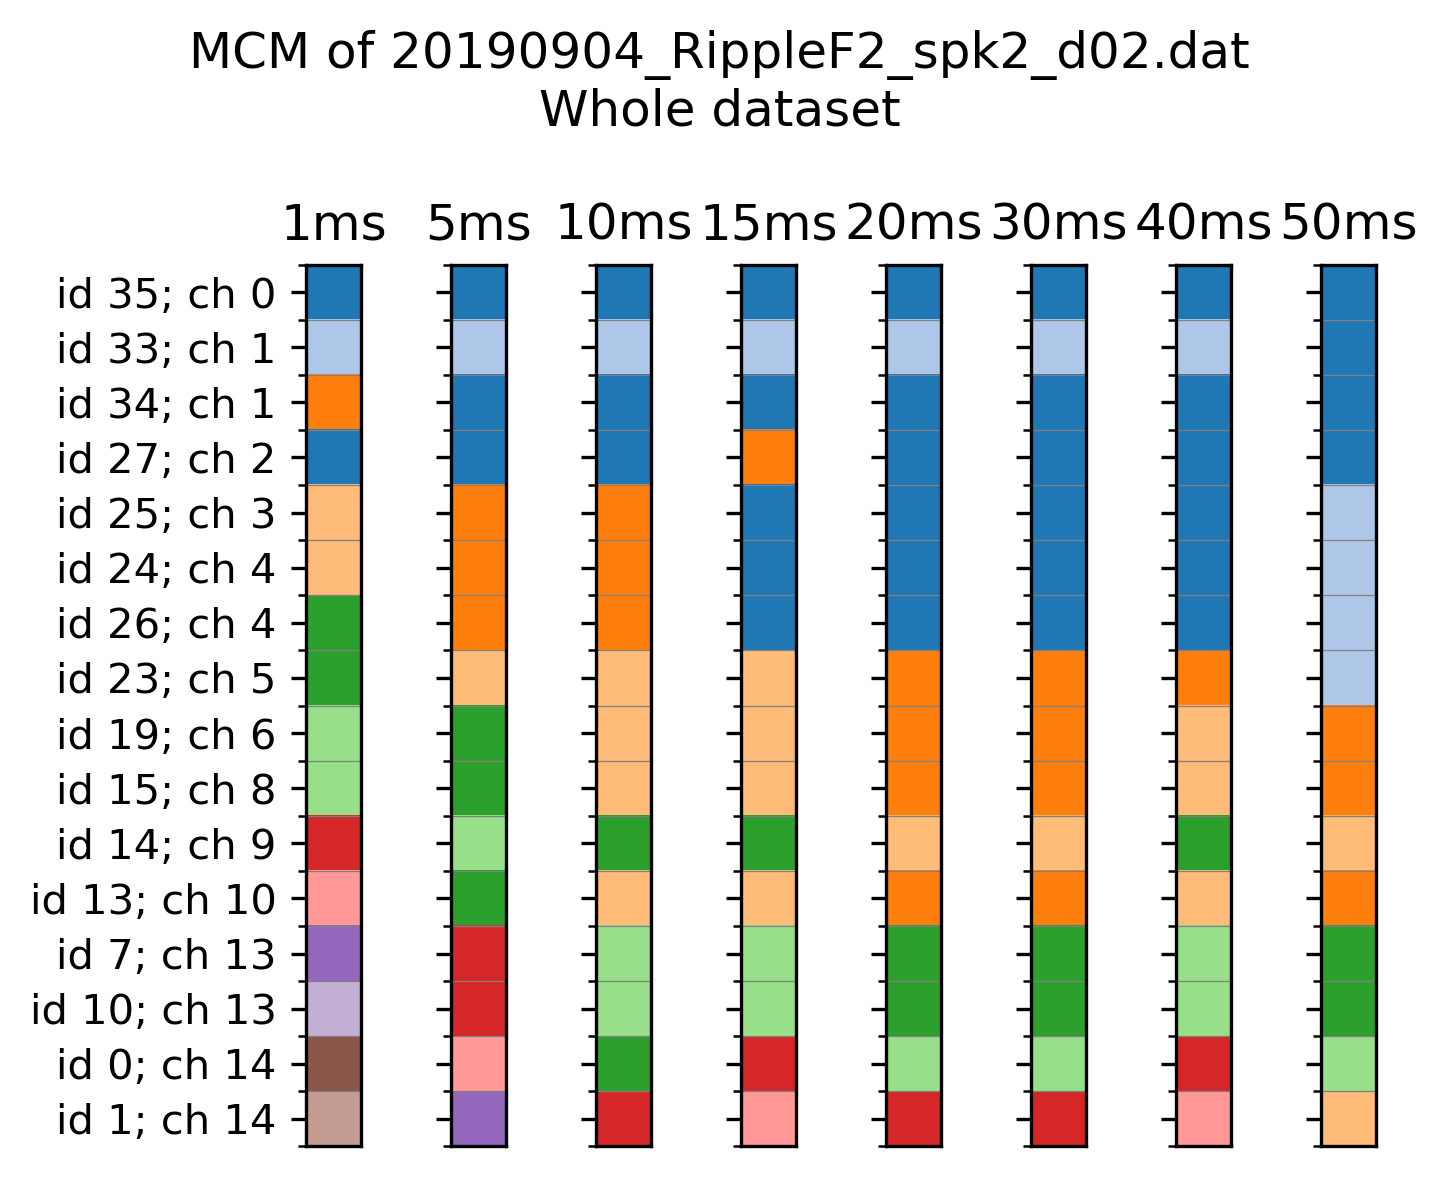

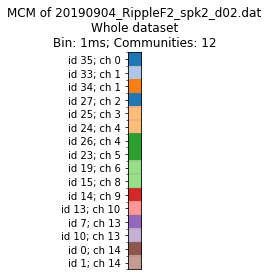

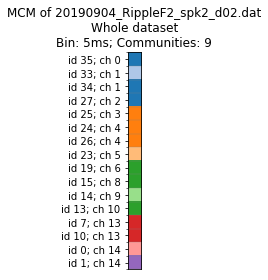

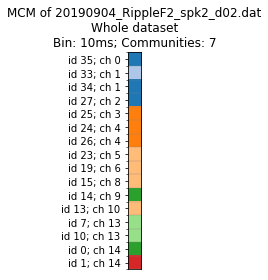

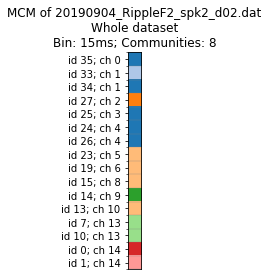

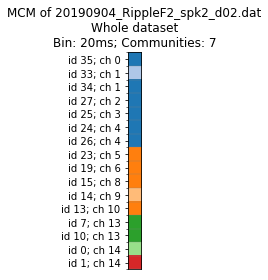

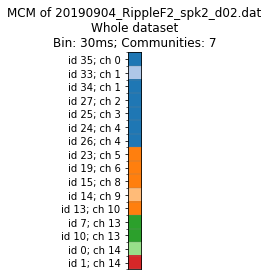

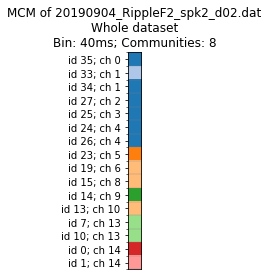

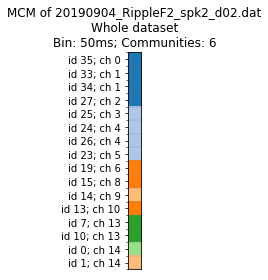

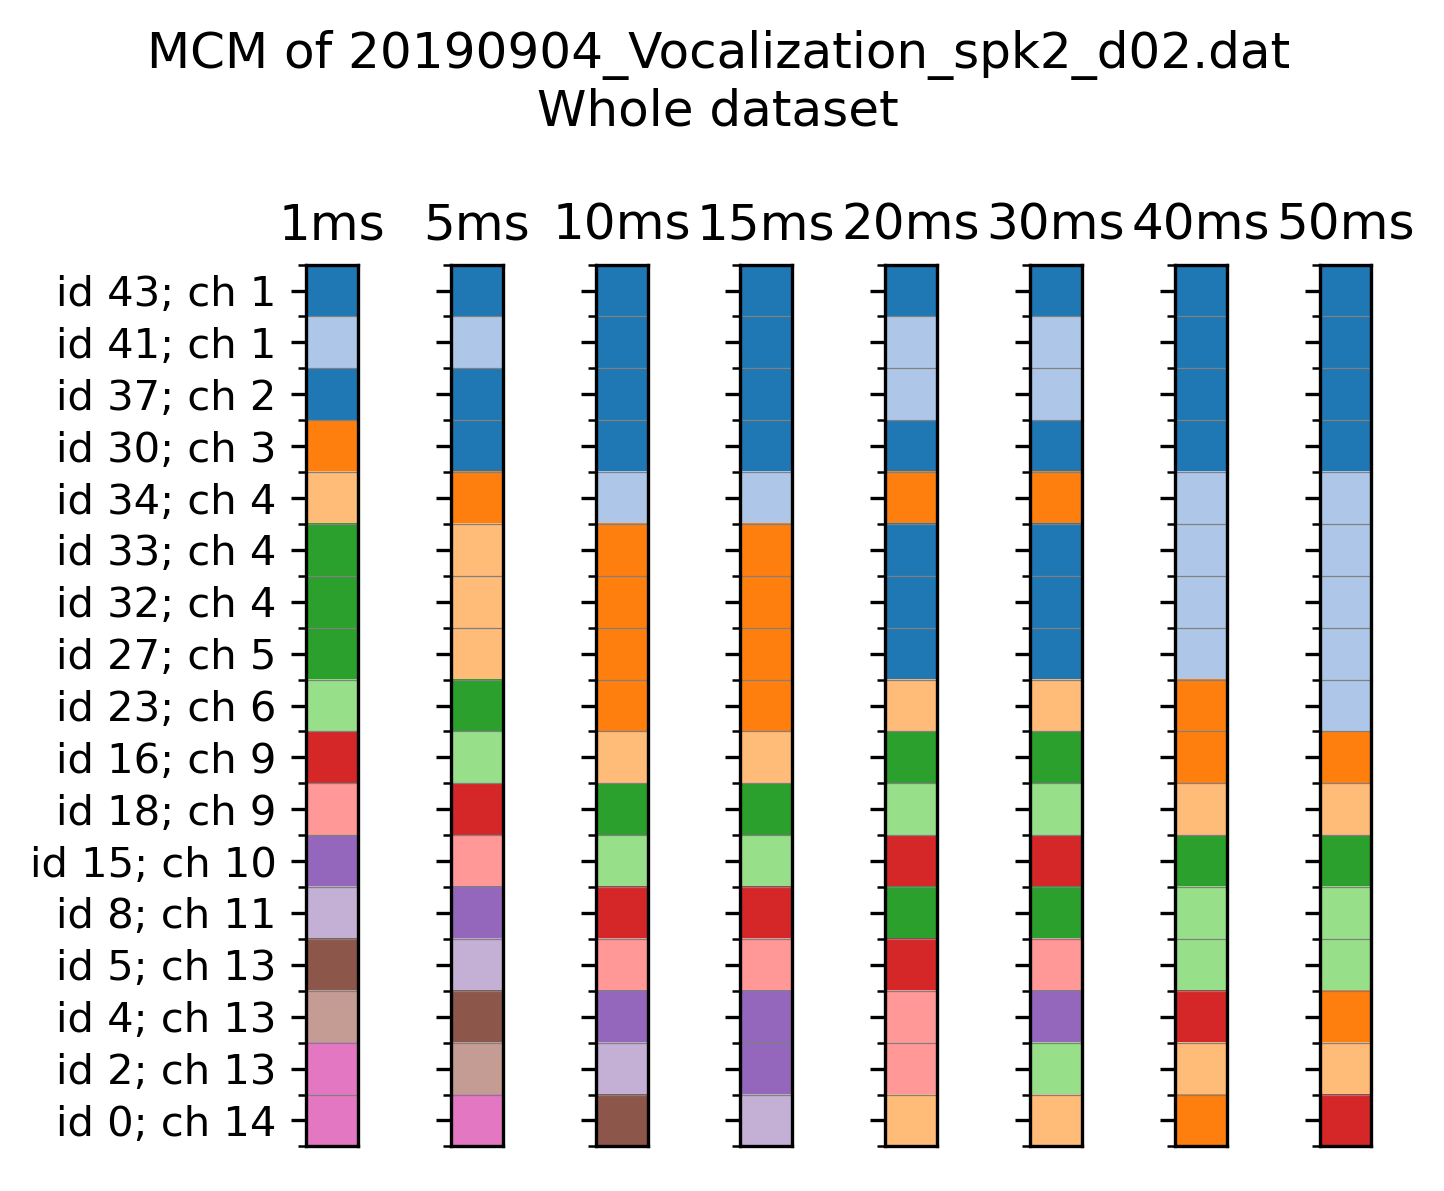

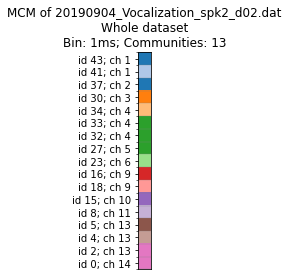

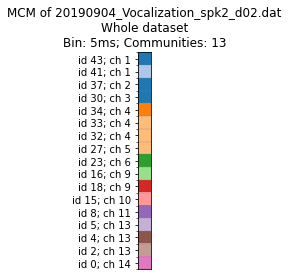

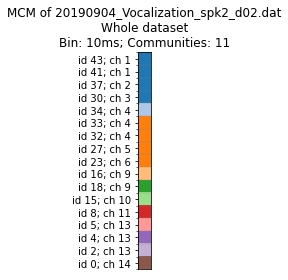

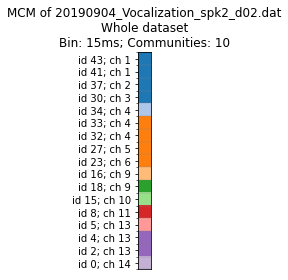

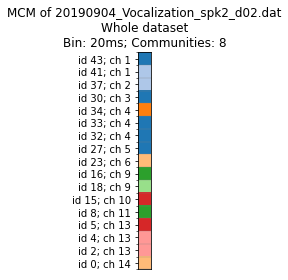

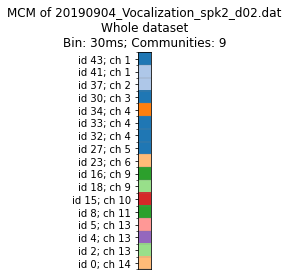

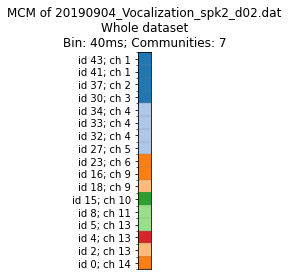

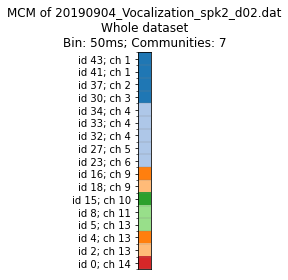

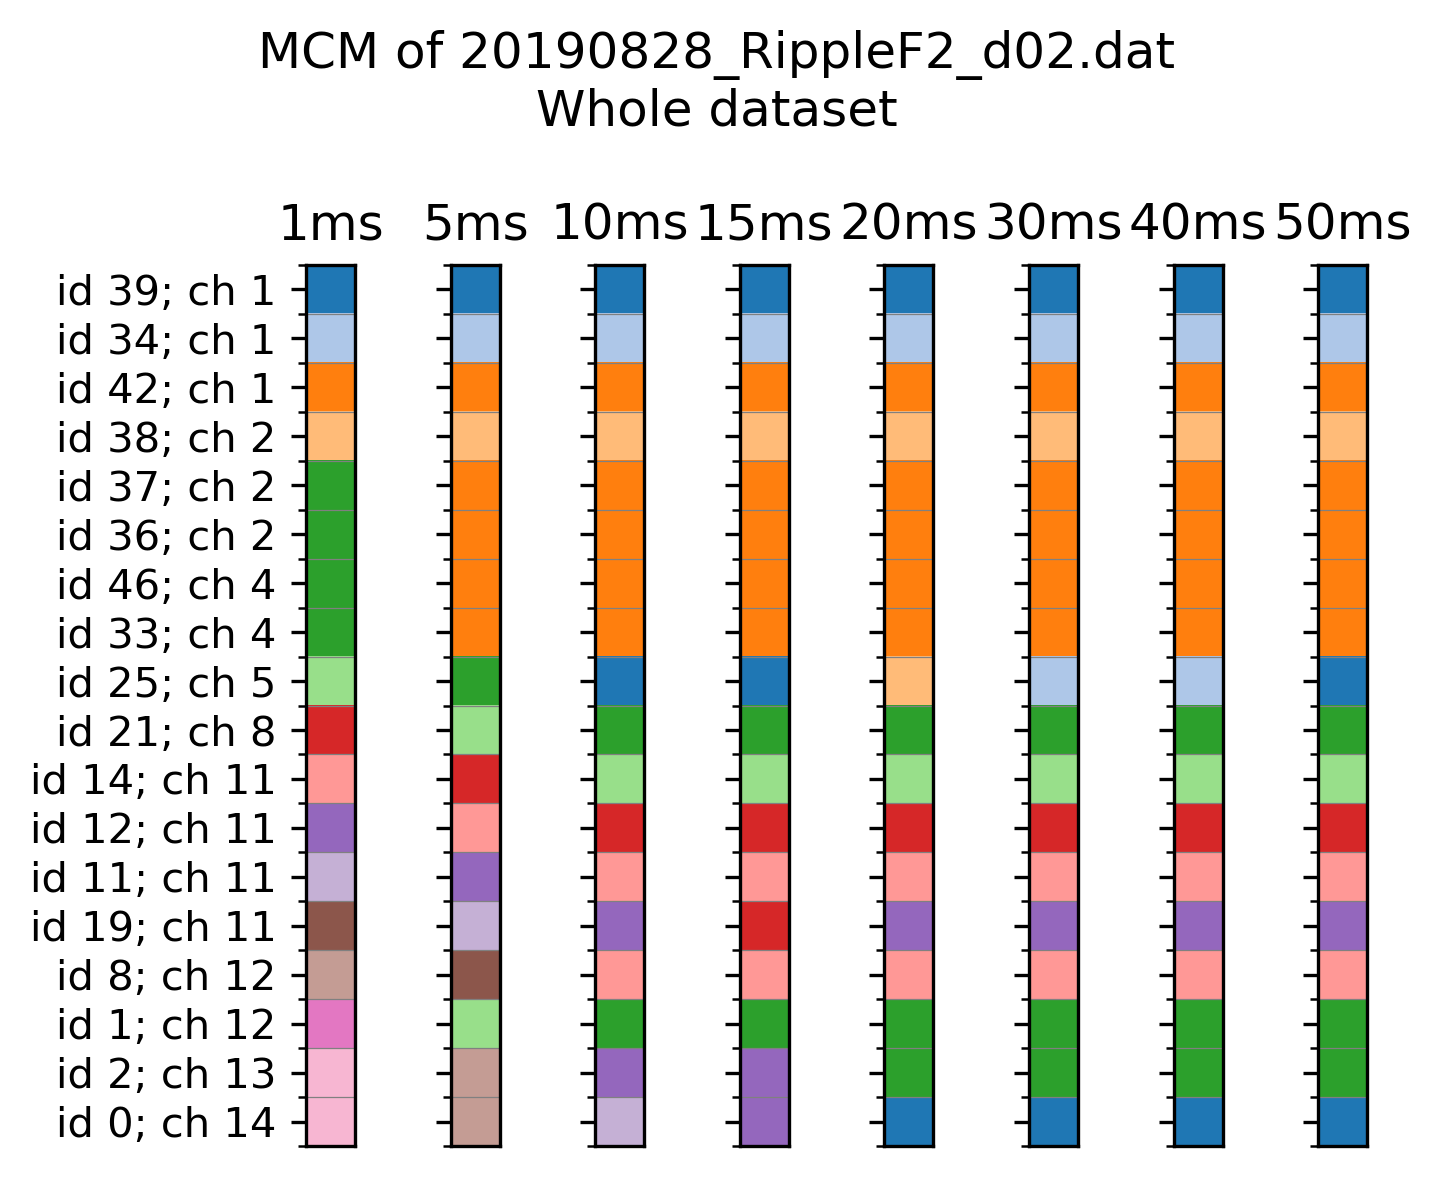

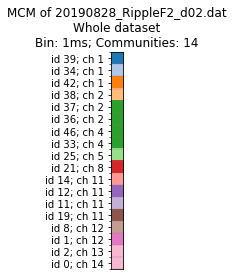

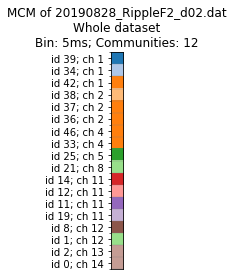

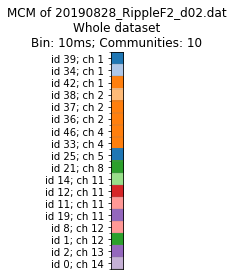

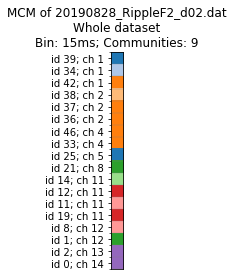

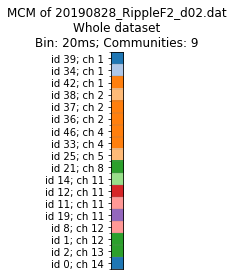

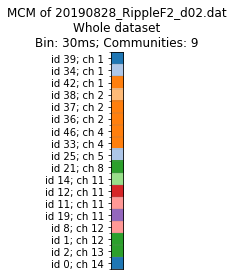

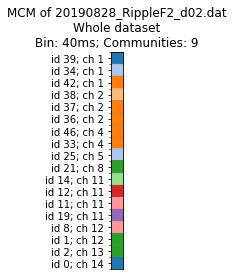

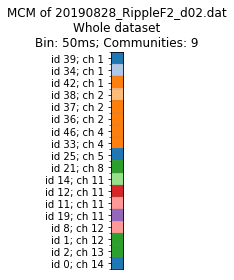

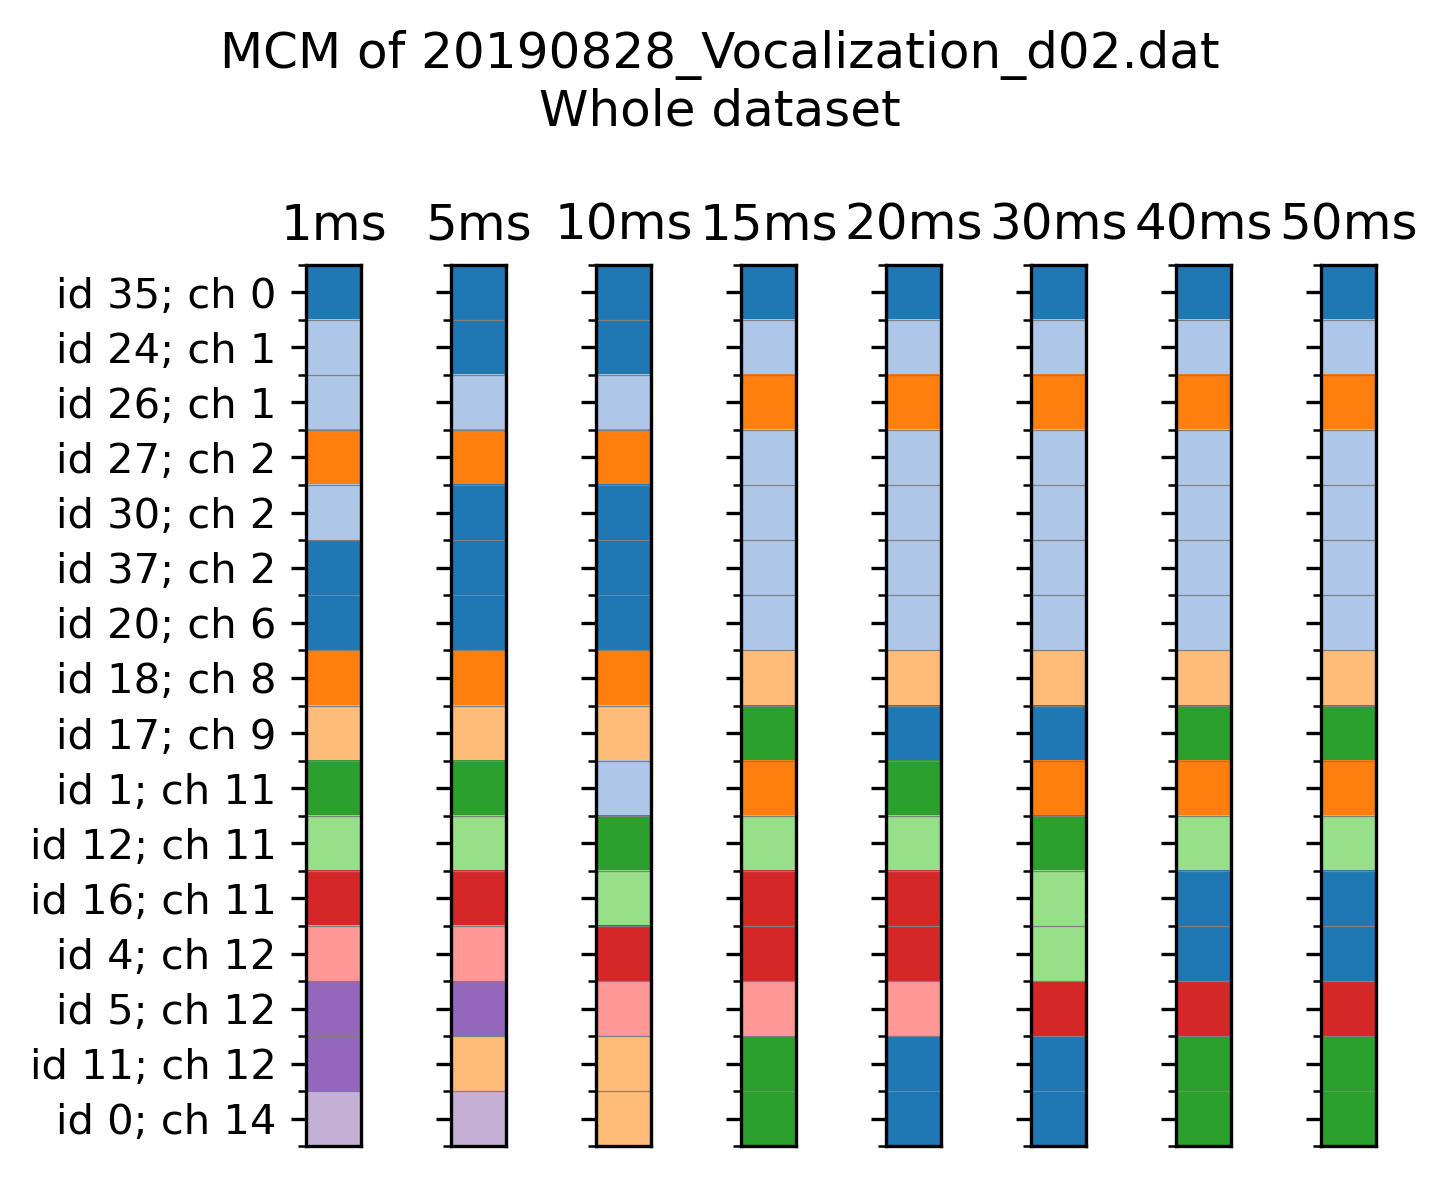

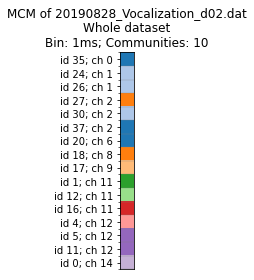

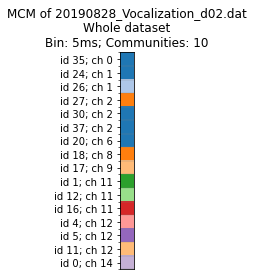

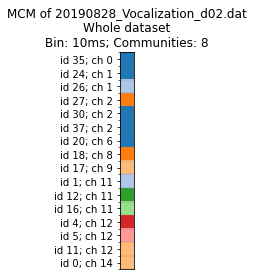

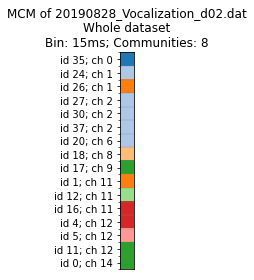

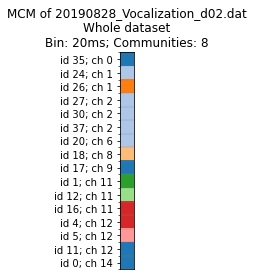

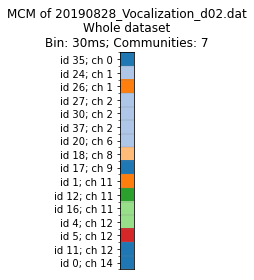

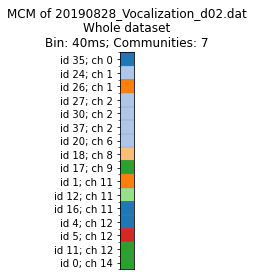

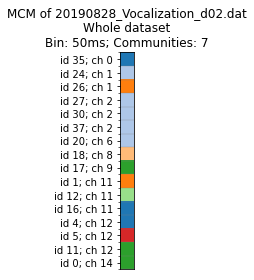

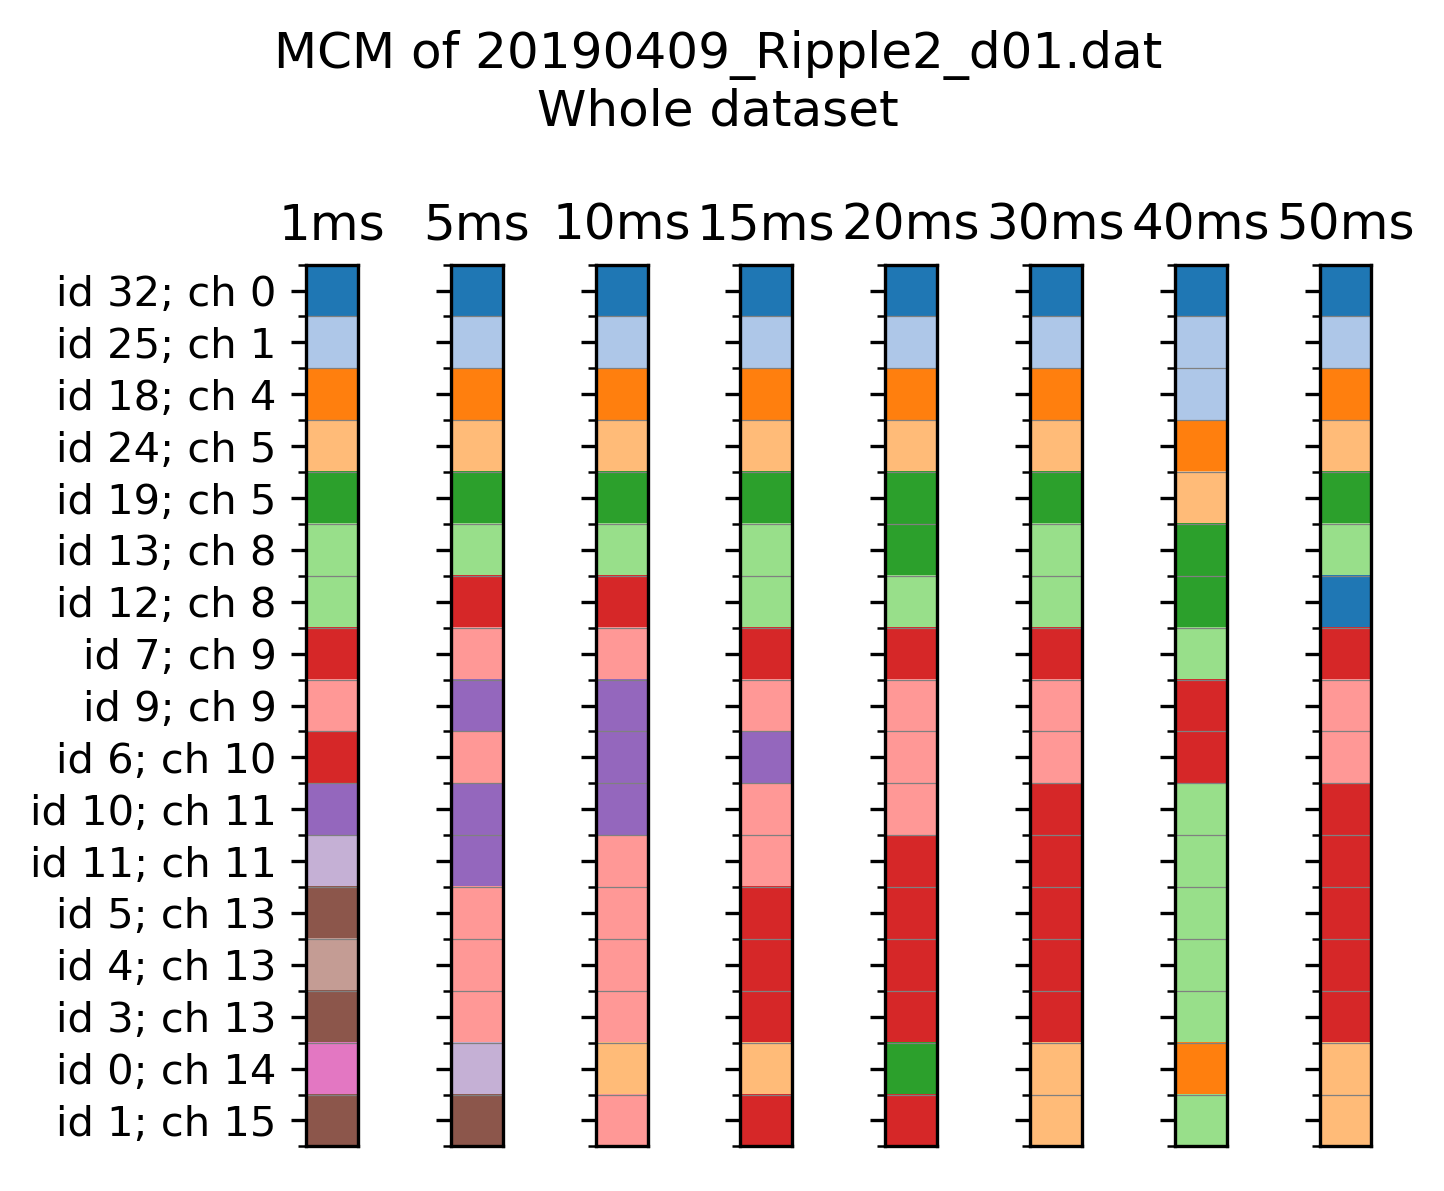

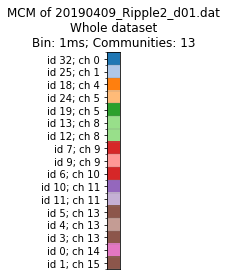

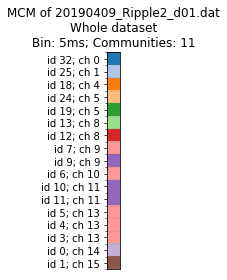

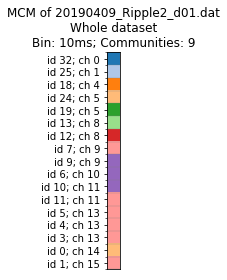

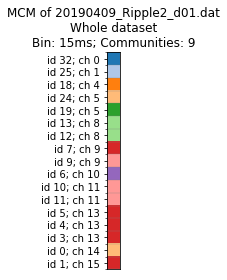

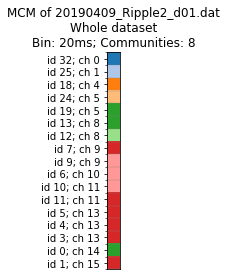

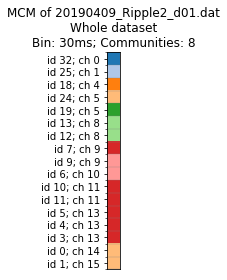

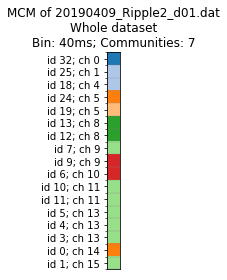

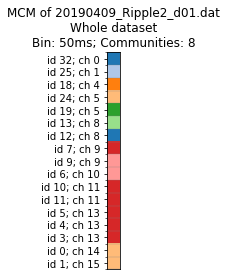

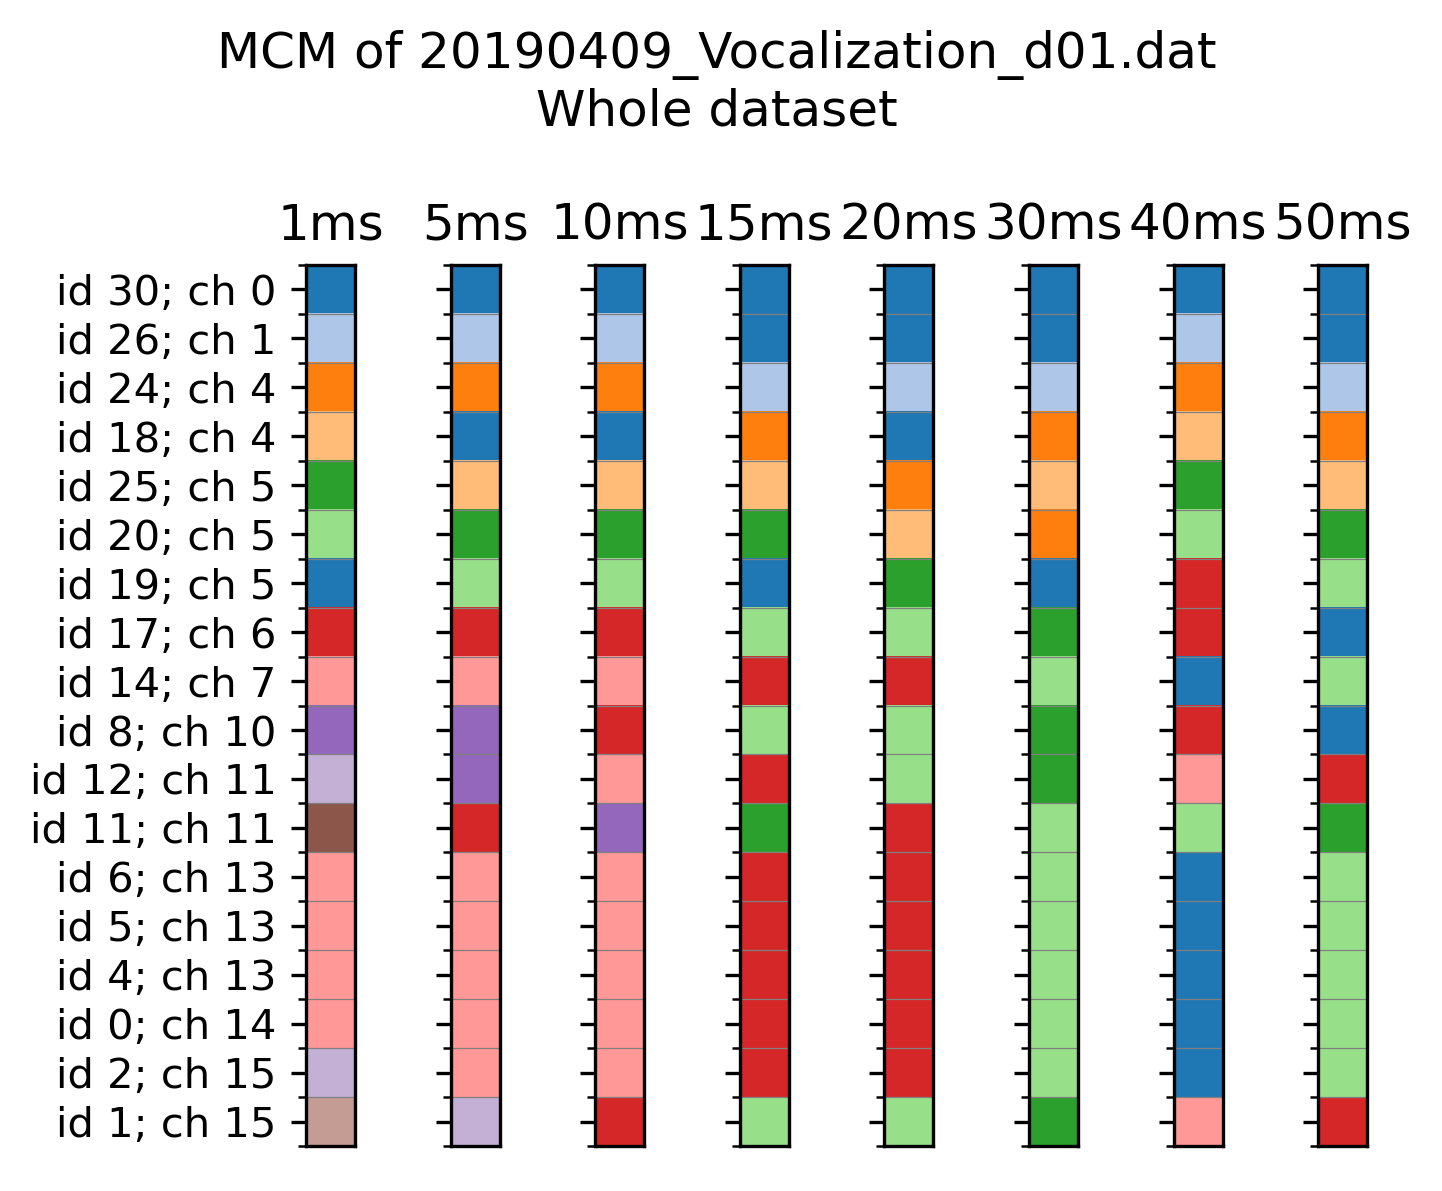

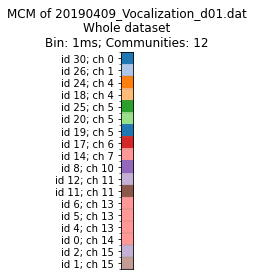

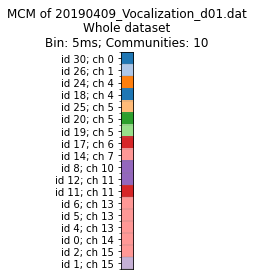

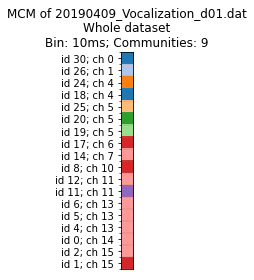

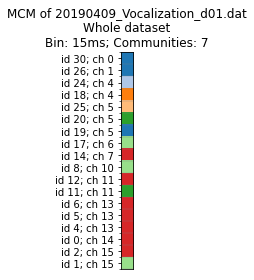

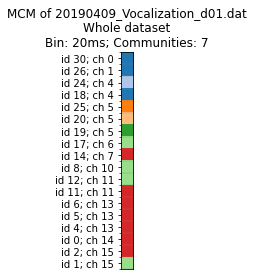

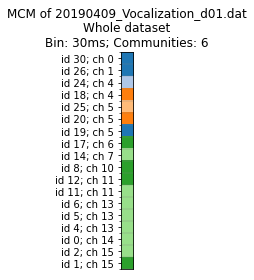

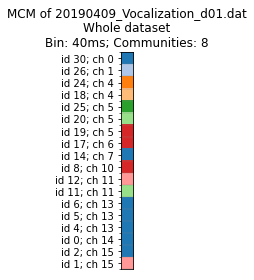

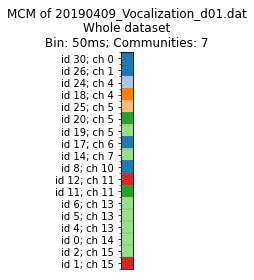

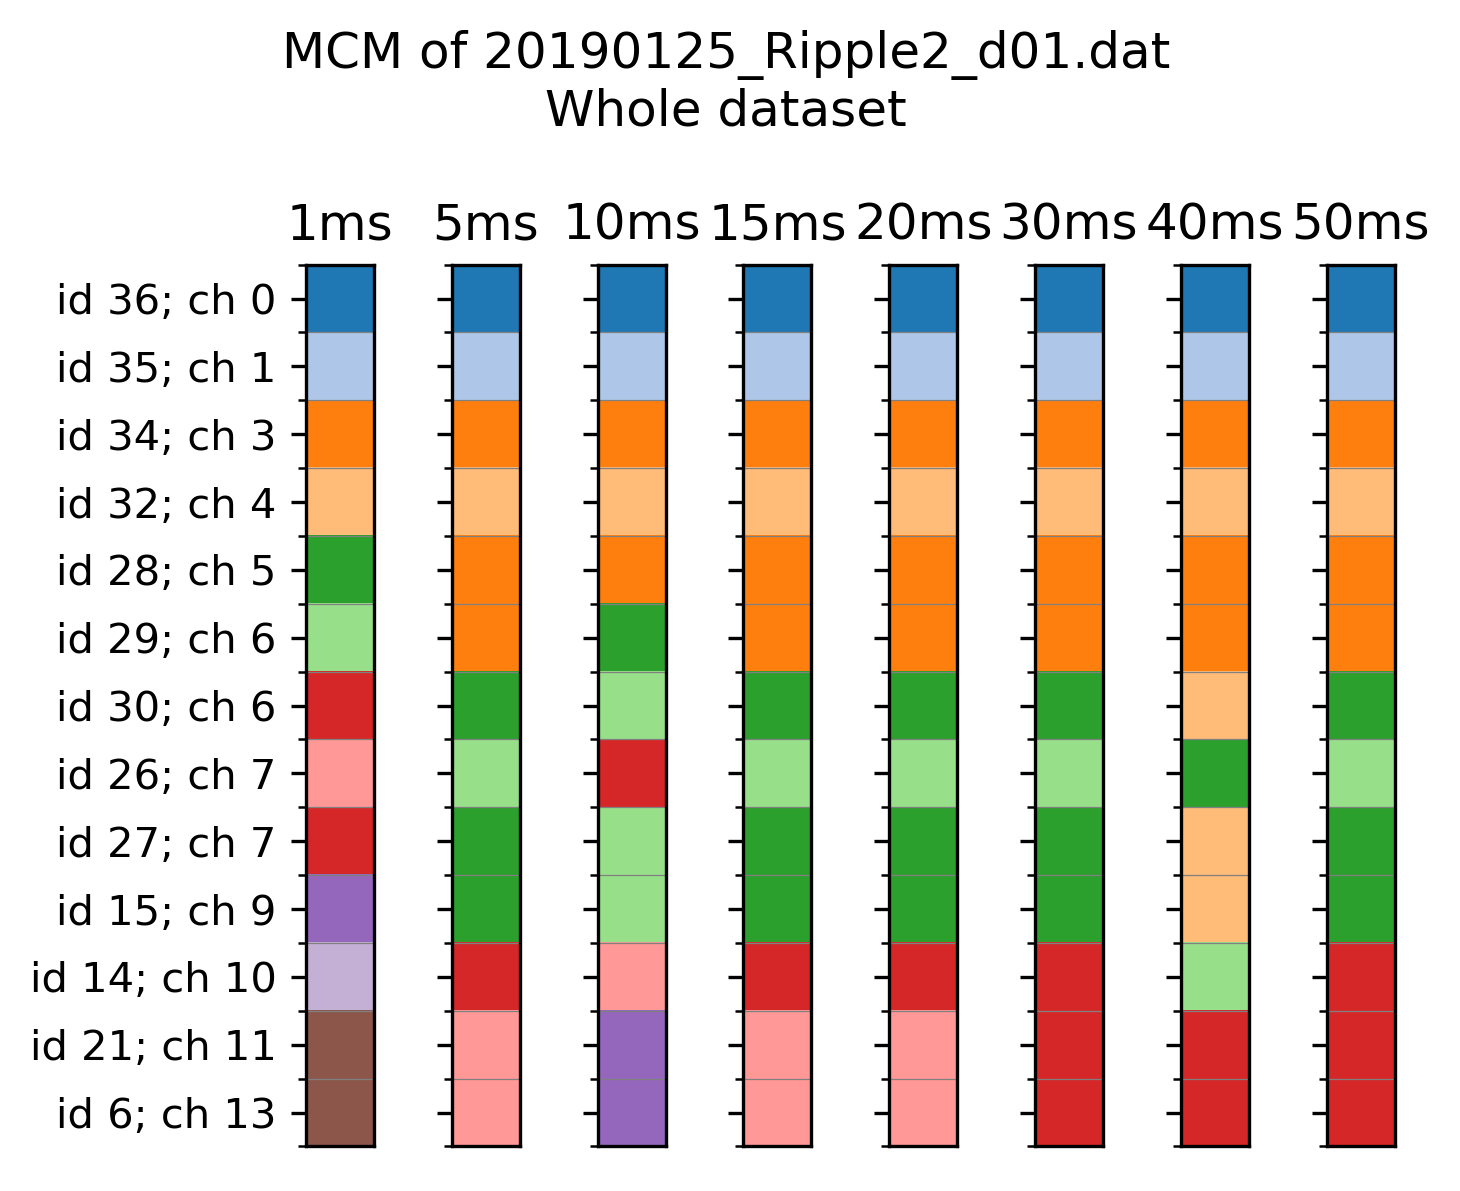

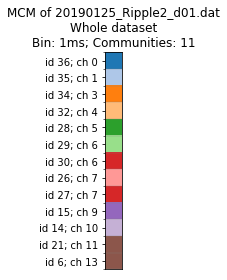

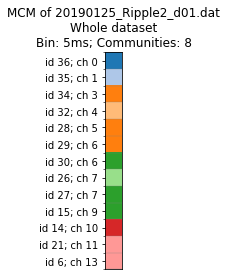

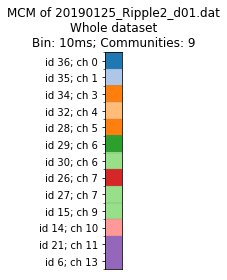

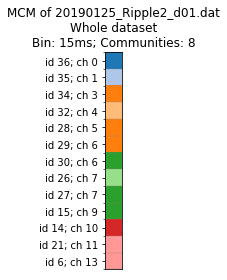

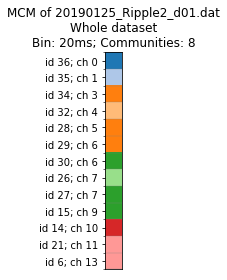

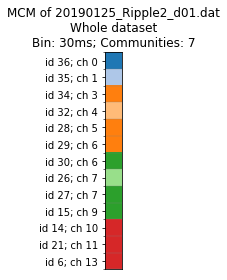

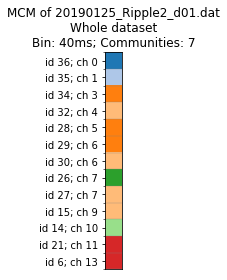

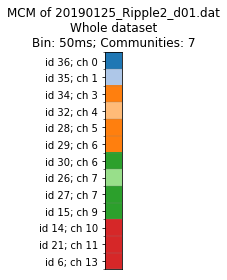

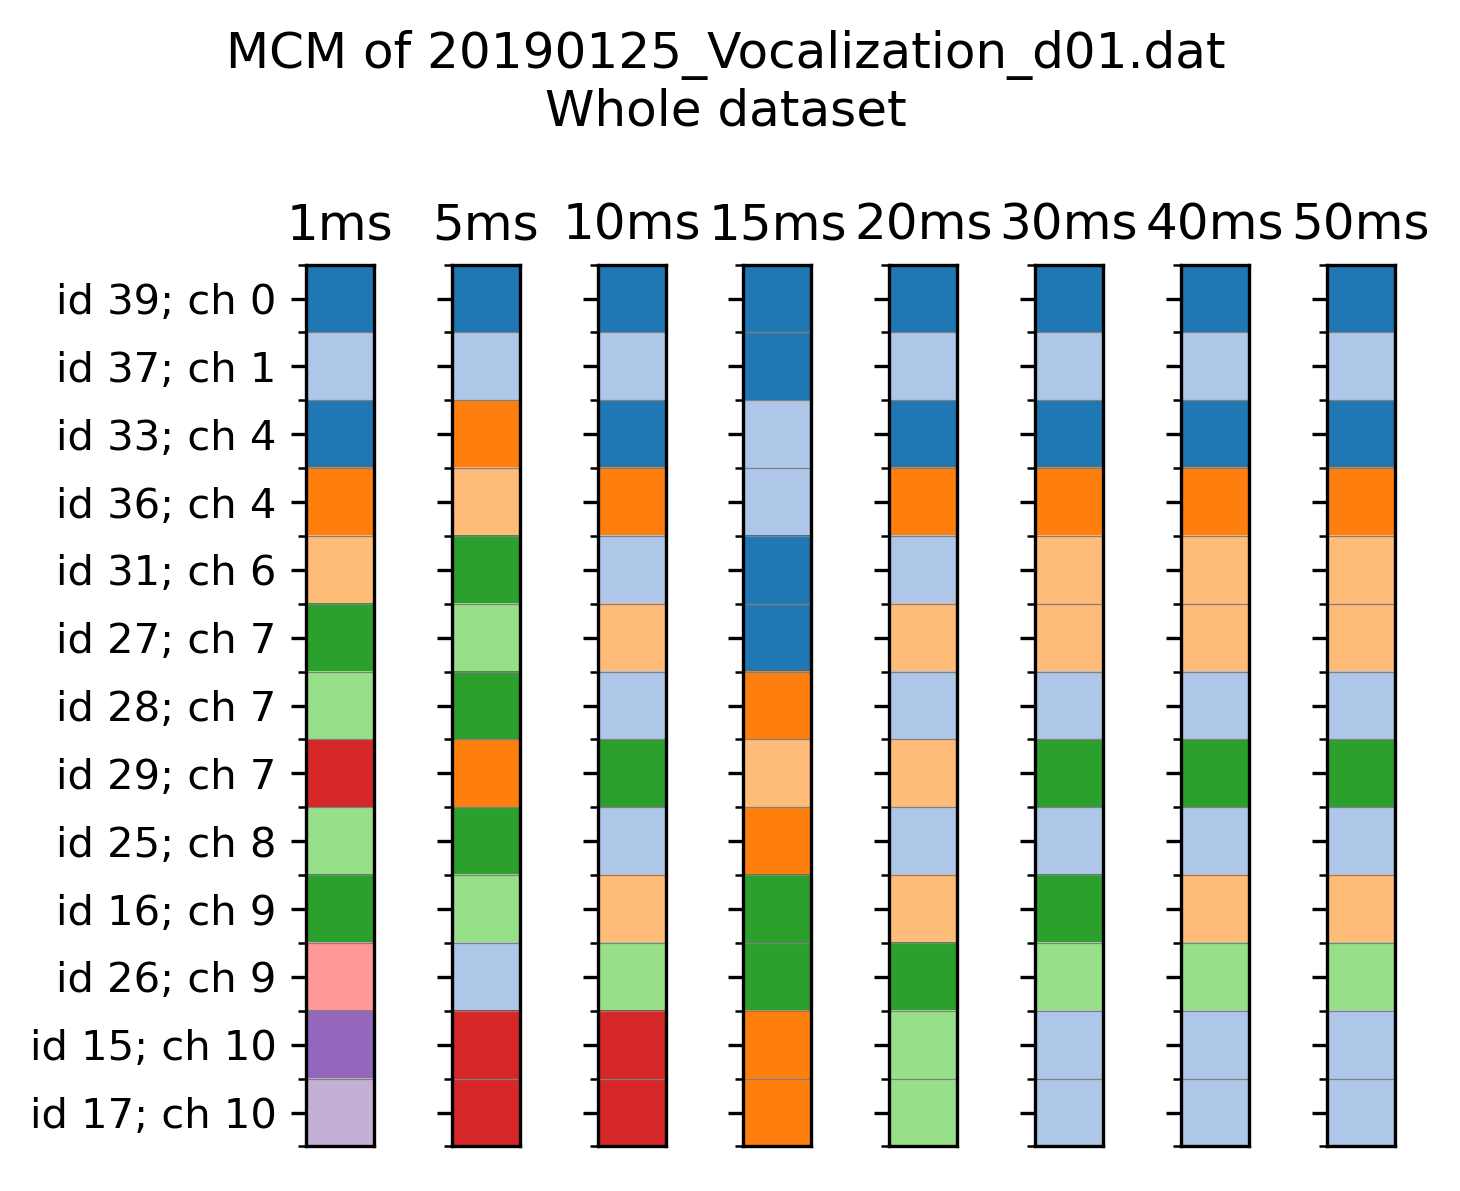

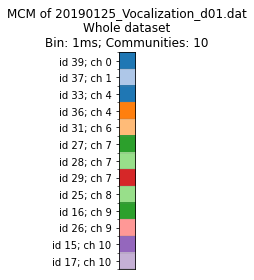

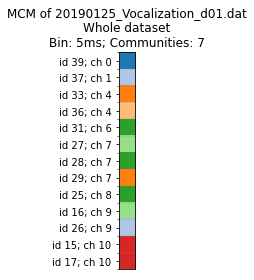

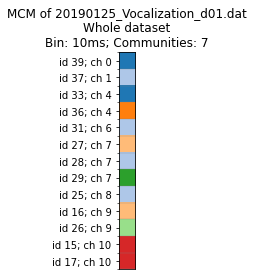

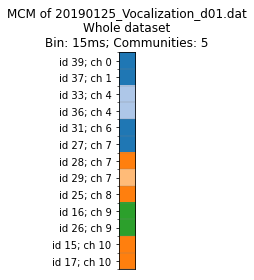

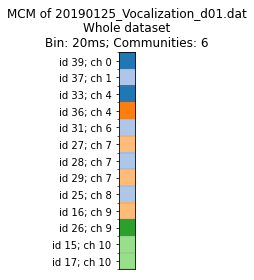

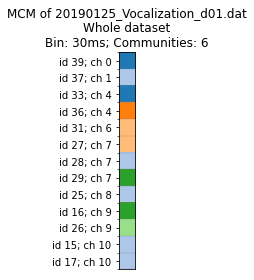

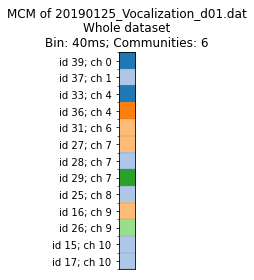

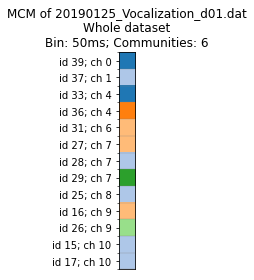

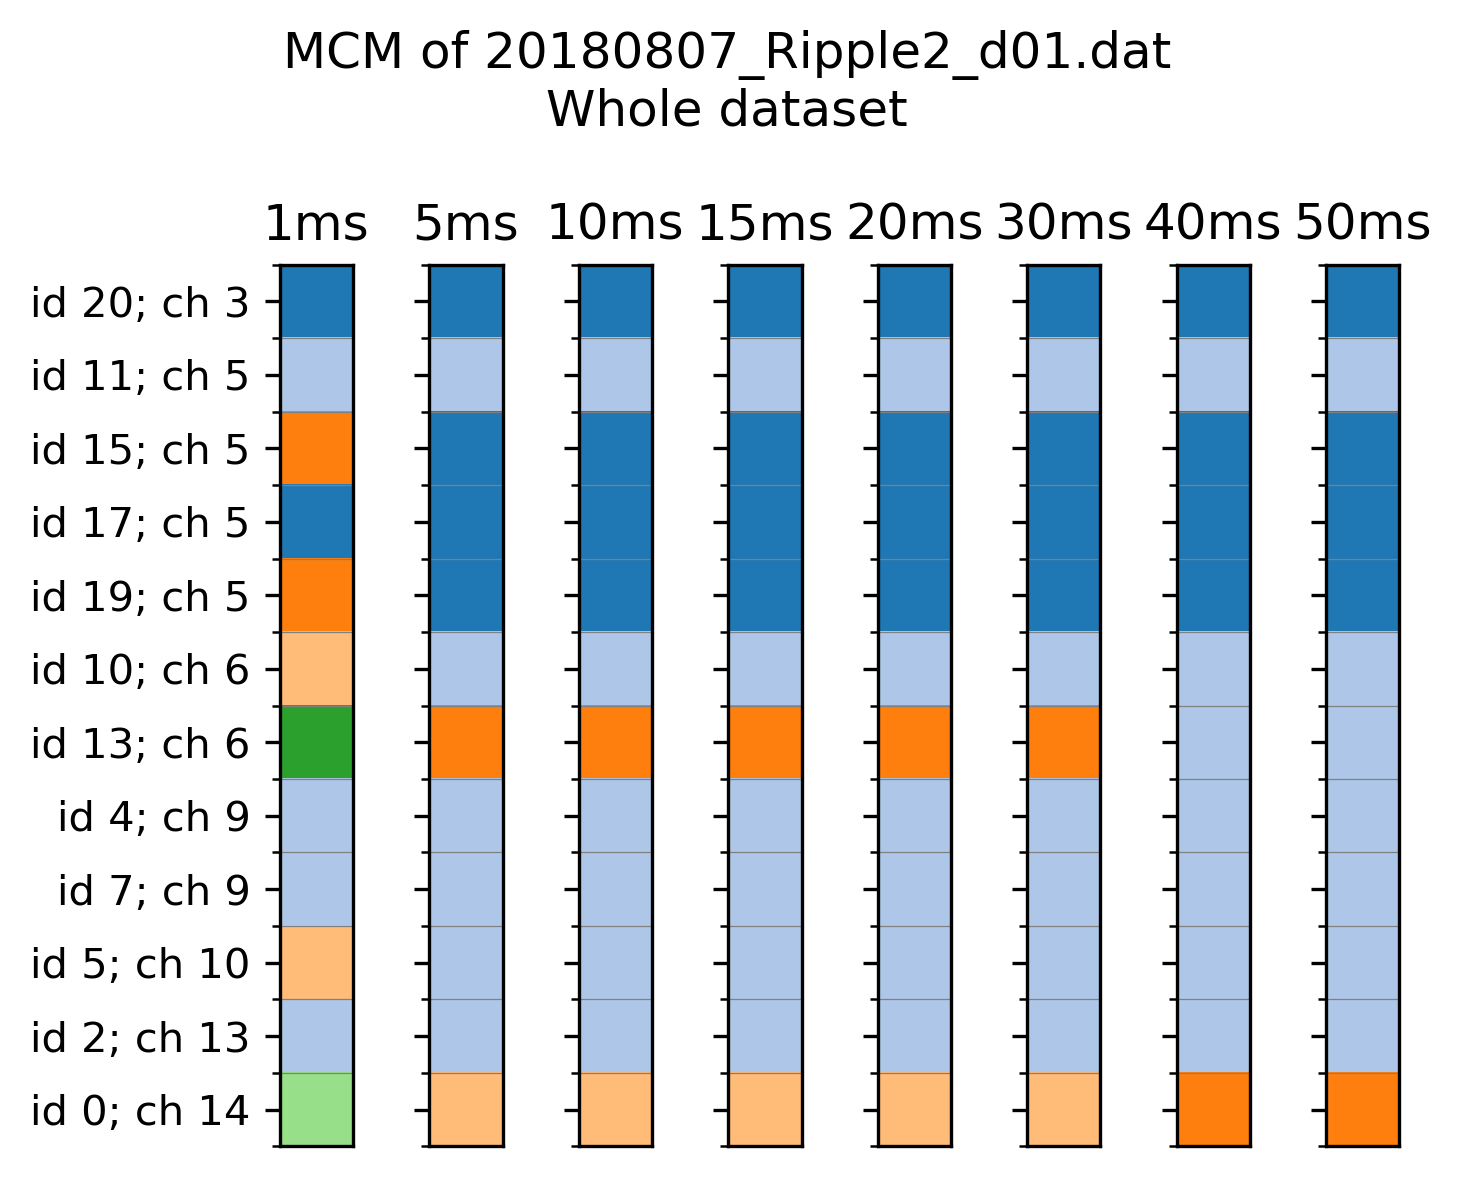

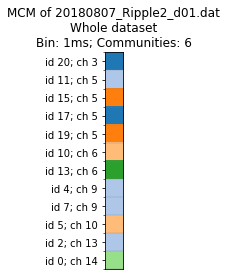

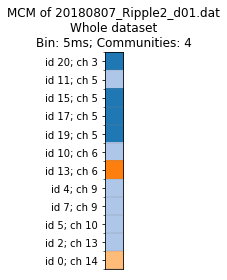

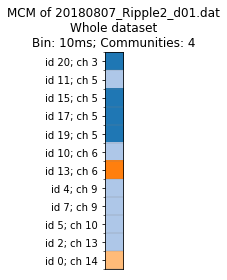

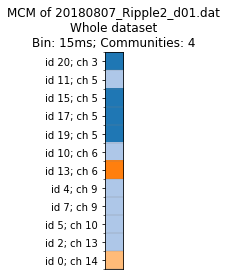

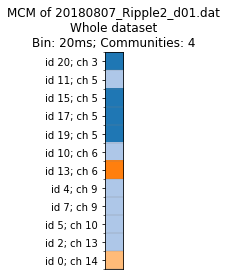

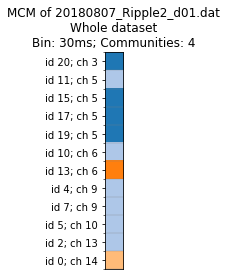

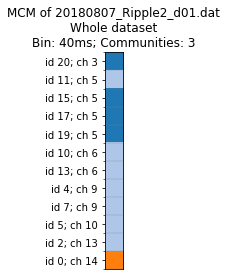

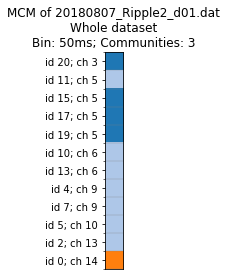

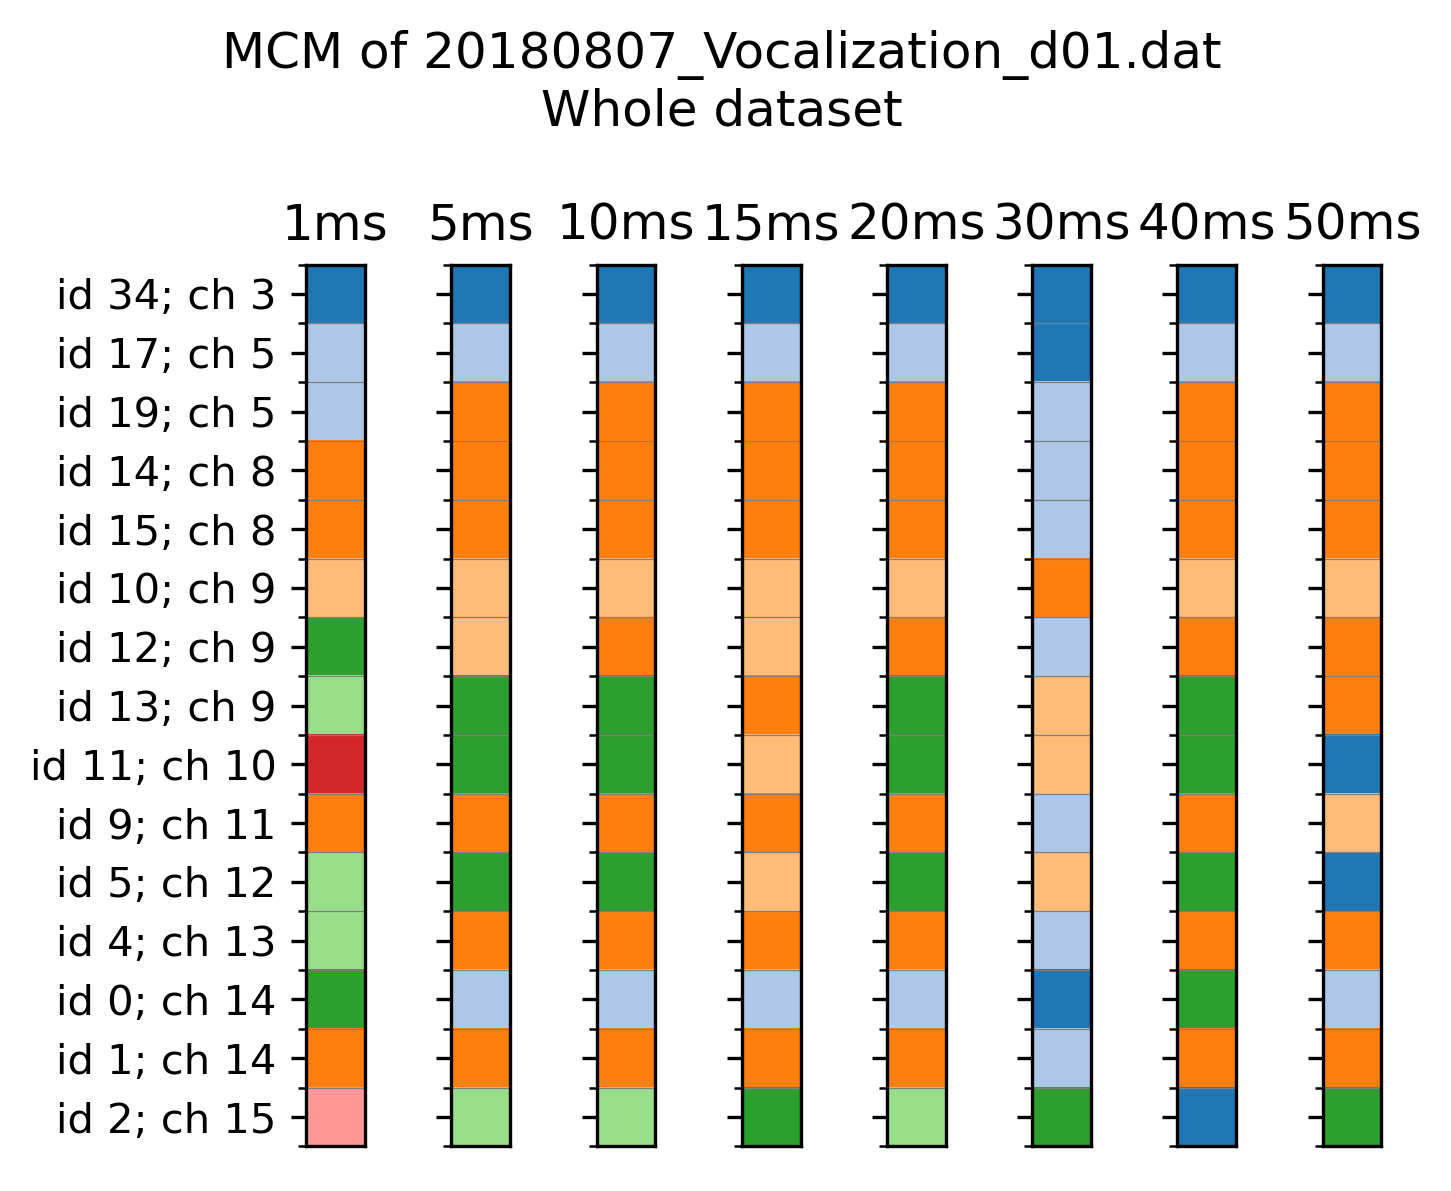

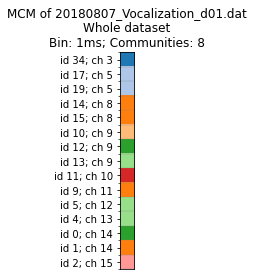

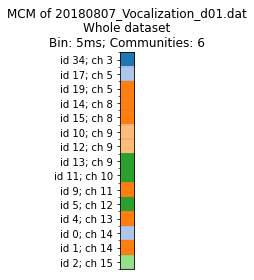

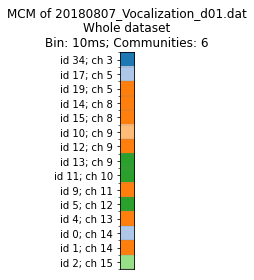

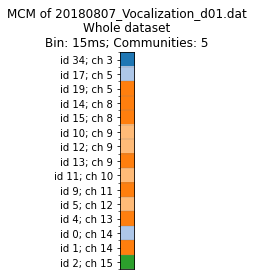

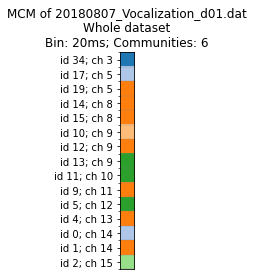

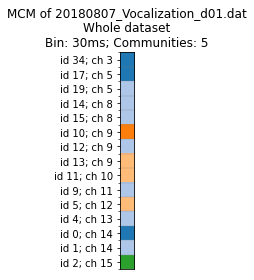

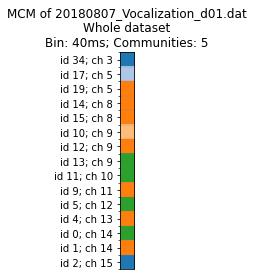

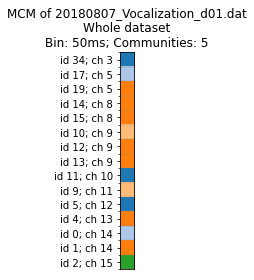

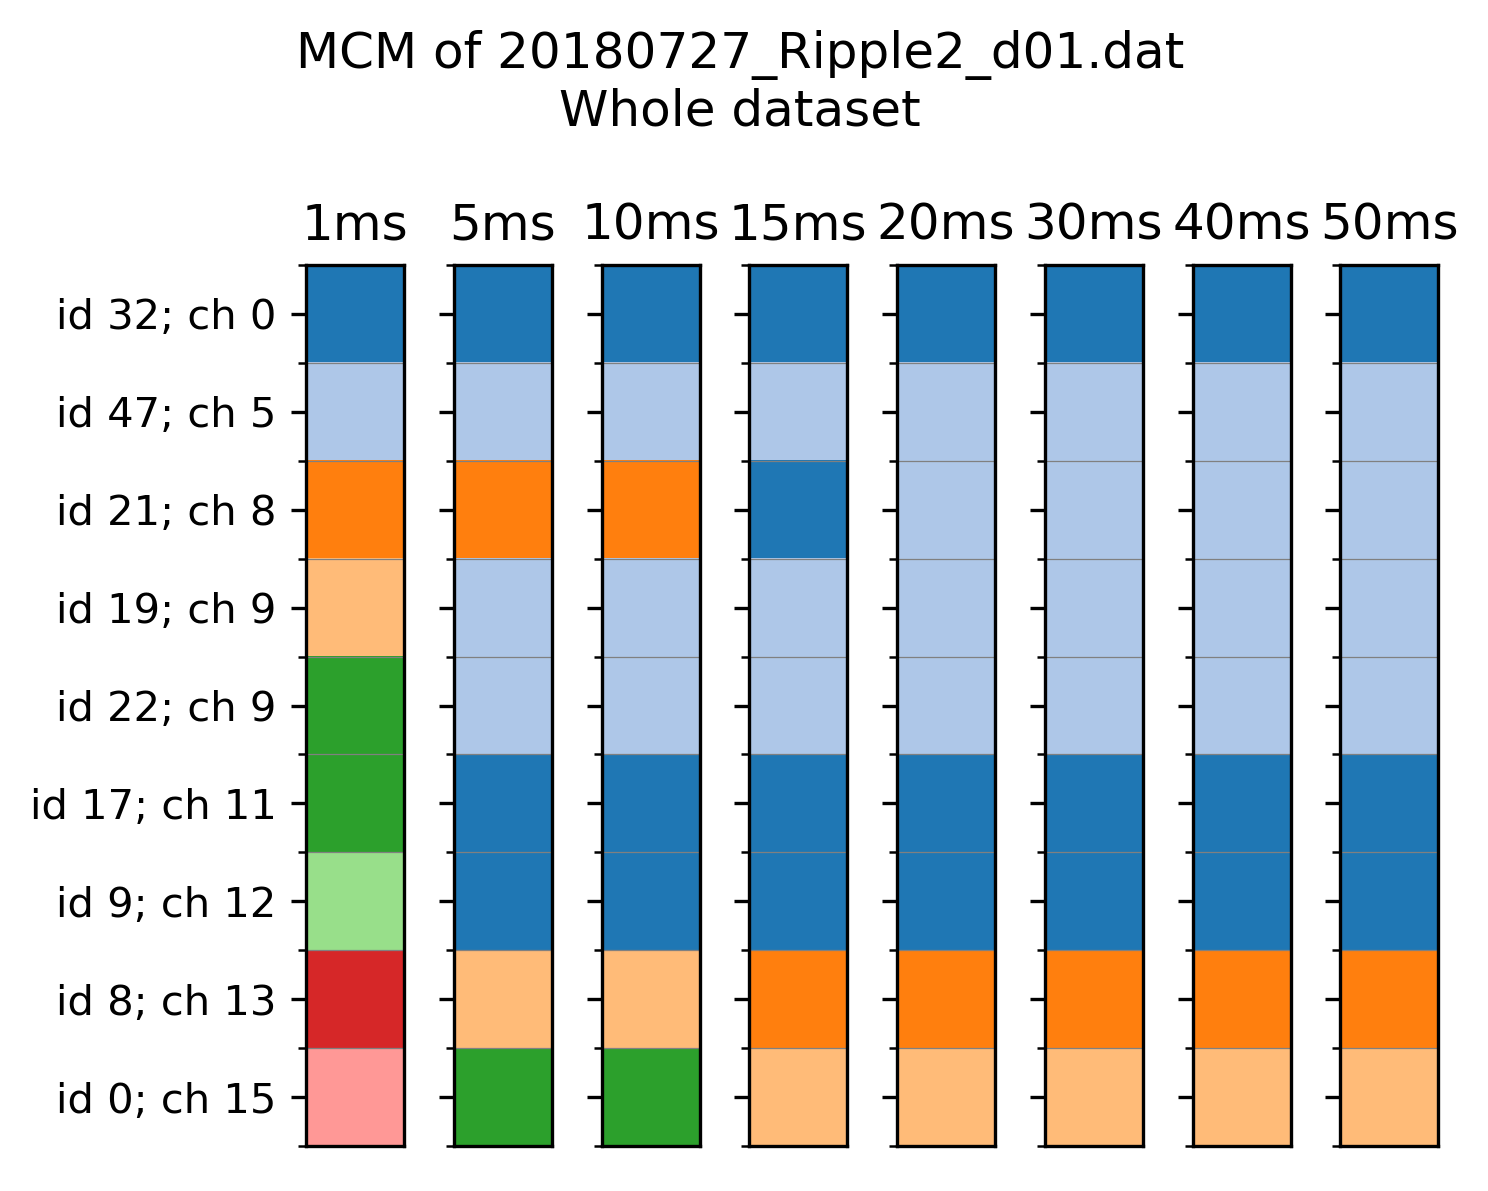

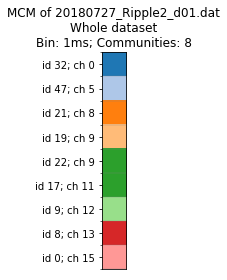

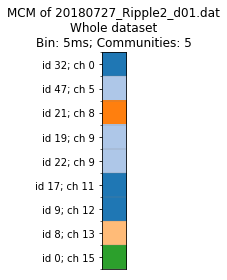

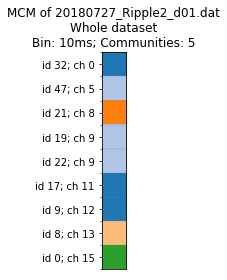

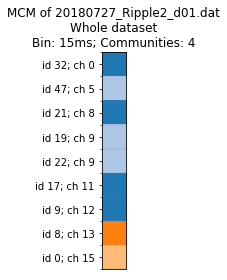

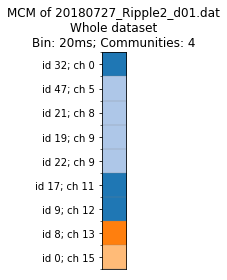

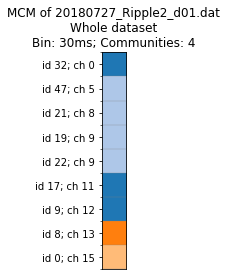

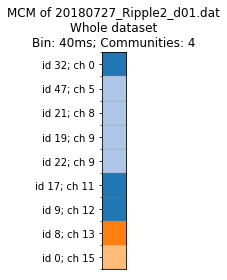

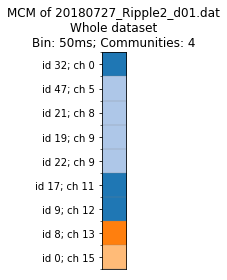

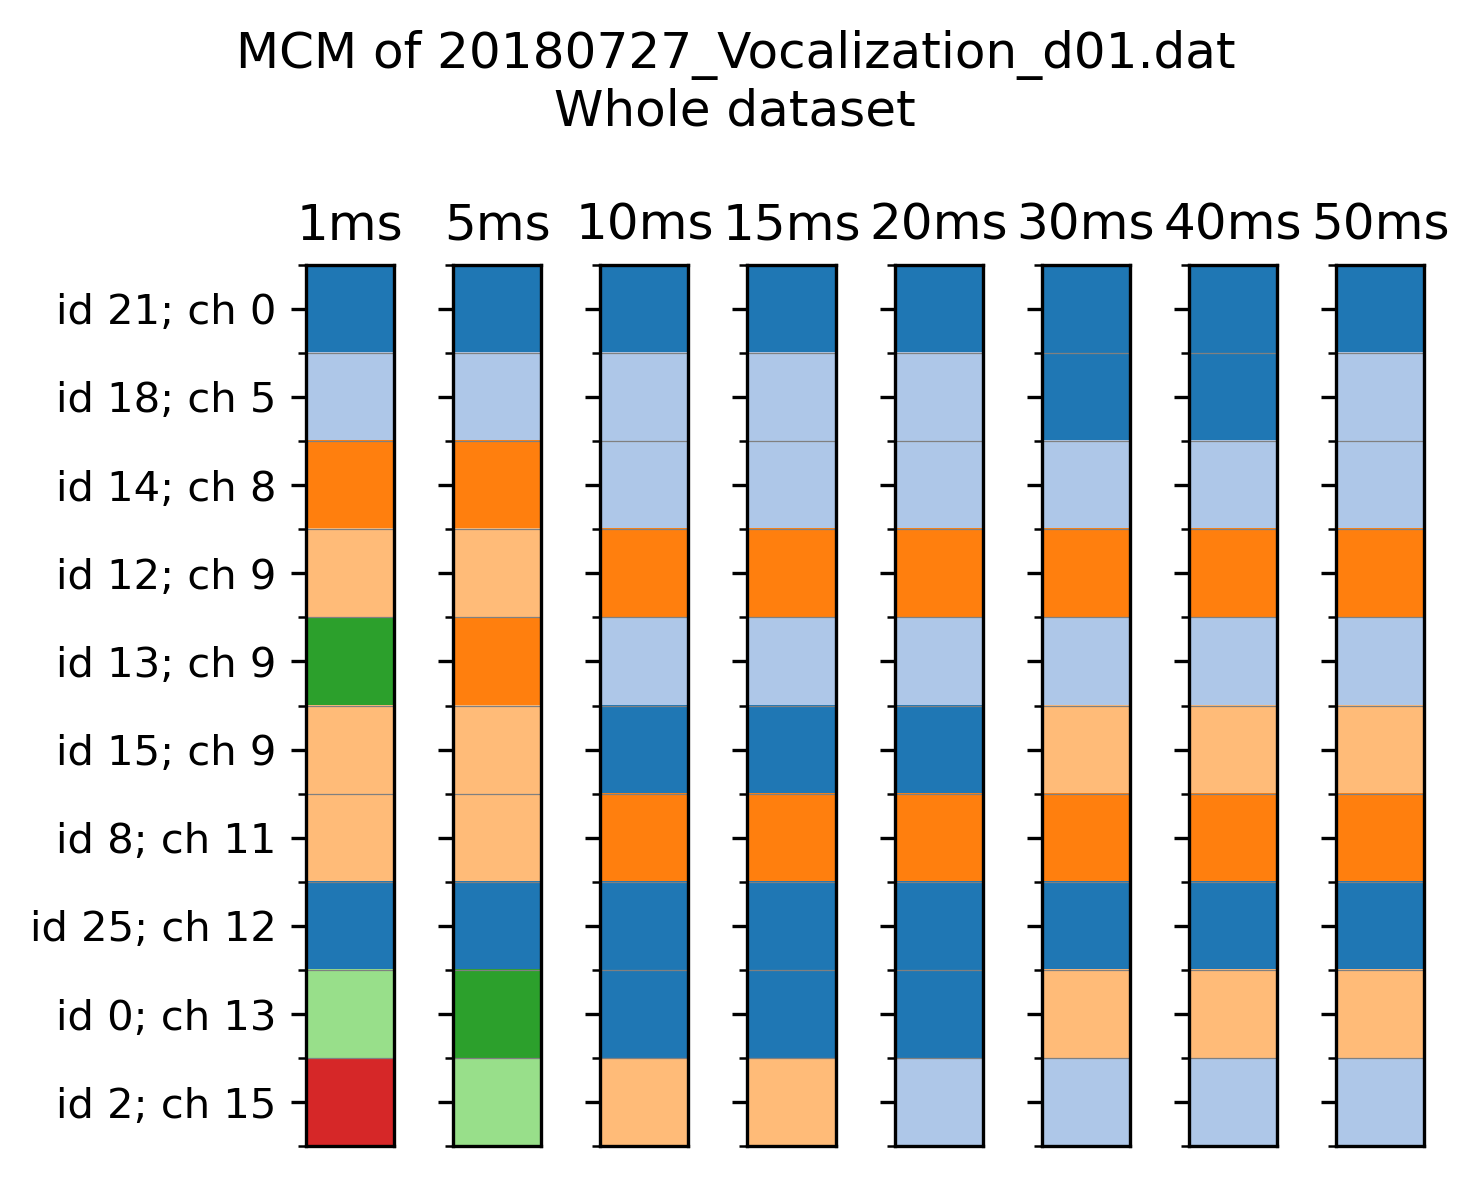

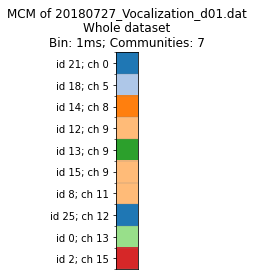

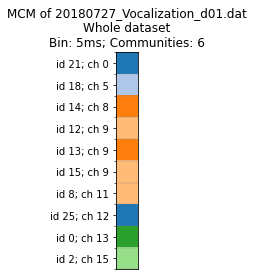

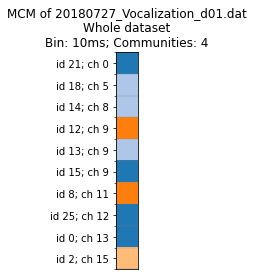

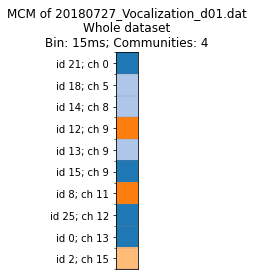

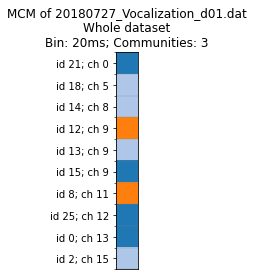

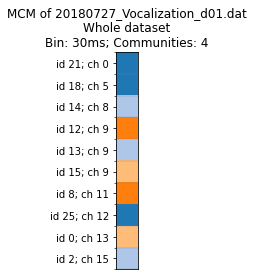

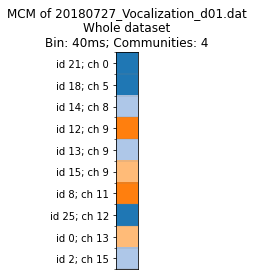

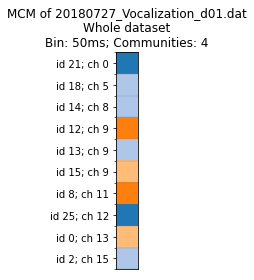

In [10]:
for file in file_list:
    date = file[0:8]
    #panel figure
    groupsave = save_path + file + '/'#+ date + '_MCMpanel.jpg'
    if not os.path.exists(groupsave):
        os.makedirs(groupsave) #make new folder
    groupsave = groupsave + date + '_MCMpanel.jpg'
    groupsave2 = save_path2 + file + '/' + date + '_MCMpanel.jpg'
    figs, axs = plt.subplots(1, 8, sharex=True, sharey=True, figsize=(5,4), dpi = 300)
    
    path = folder_path + file + '/'
    
    neuron_file = path + date + '_neuronlabels.txt'
    neurons = pd.read_csv(neuron_file, header = None, names = ['id', 'channel'])
    neurons_id = neurons['id'].to_numpy().flatten()
    neurons_channel = neurons['channel'].to_numpy().flatten()
    n = len(neurons)
    print("n = ",n)
        
    #make txt file to save results
    textfile = savepath + file + '/results.txt'
    f = open(textfile, 'w')
    title_file = file + '\n\n'
    f.write(title_file)
    
    for binsec, a in zip(bins, range(8)):
        print('file: ', file)
        print('bin: ', binsec)
        
        MCMsave = save_path + file + '/' + date + '_bin' + binsec + '_MCM.jpg'
        MCMsave2 = save_path2 + file + '/bin_' + binsec + '/' + date + '_bin' + binsec + '_MCM.jpg'
        
        #make filename
        filename = path + date + '_binsec' + str(binsec) + '.dat'
        #Kset, N = read_data(filename)
        Kset, N, n_channel, n_id = channel_order(filename, neurons_channel, neurons_id)
        
        #make labels
        x_label_list = []
        for i in range(n):
            label = "id " + str(n_id[i]) + "; ch " + str(n_channel[i])
            x_label_list.append(label)
        
        #make MCM
        MCM, logE = merging(Kset)
        #print_partition(MCM)
        
        #put information in the text file
        bin_title = "bin: " + binsec + 'ms\n'
        f.write(bin_title)
        log_evidence = f'log-evidence: {logE:.2f}\n'
        f.write(log_evidence)
        independent = {i : 1 << i for i in range(n)}
        complete = {0 : sum(MCM.values())}
        f.write("### Complete ###\n") ## Distance of found MCM to a partition of one big community
        fwrite = str(var_of_info(MCM,complete)) + '\n'
        f.write(fwrite)
        fwrite = str(norm_mut_info(MCM,complete)) + '\n'
        f.write(fwrite)
        f.write("### Independent ###\n") ## Distance of found MCM to a partition of all nodes being separate communities
        fwrite = str(var_of_info(MCM,independent)) + '\n'
        f.write(fwrite)
        fwrite = str(norm_mut_info(MCM,independent)) + '\n'
        f.write(fwrite)
        f.write('\n')
        
        #make matrix 
        partitions = np.zeros(n)
        for i in range(len(MCM)):
            index = np.where(get_partition(MCM,list(MCM.keys())[i])) #get index of ones
            partitions[index] = ((i + 1)/20)-0.01
        #print(partitions)
        #convert to 1-D matrix for fig
        partitions = np.flip(partitions)
        #print(partitions)
        partitions = np.array(partitions).reshape((n,1))
        
        #make heatmap
        fig, ax = plt.subplots(1,1)
        img = ax.imshow(partitions,cmap='tab20')#'viridis')
        ax.get_xaxis().set_visible(False)
        #ax.set_xticklabels(x_label_list, rotation=45)
        ax.set_yticks(np.arange(n))
        ax.set_yticklabels(x_label_list)
        # Minor ticks
        #ax.set_xticks(np.arange(-.5, n, 1), minor=True)
        ax.set_yticks(np.arange(-.5, n, 1), minor=True)
        # Gridlines based on minor ticks
        ax.grid(which='minor', color='grey', linestyle='-', linewidth=0.3)
        title = 'MCM of ' + file + '\nWhole dataset\nBin: '+ binsec + 'ms; Communities: ' + str(len(MCM))
        ax.set_title(title)
        img.set_clim(0,1)
        #fig.colorbar(img)
        fig.tight_layout()
        fig.savefig(MCMsave, dpi = 300)
        fig.savefig(MCMsave2, dpi = 300)
        fig.show()

        #panel figure
        img = axs[a].imshow(partitions,cmap='tab20')#'viridis')
        #axs[a].set_xticks(np.arange(n))
        #axs[a].set_xticklabels(x_label_list, rotation=45)
        axs[a].get_xaxis().set_visible(False)
        axs[a].set_yticks(np.arange(n))
        axs[a].set_yticklabels(x_label_list)
        # Minor ticks
        #axs[a].set_xticks(np.arange(-.5, n, 1), minor=True)
        axs[a].set_yticks(np.arange(-.5, n, 1), minor=True)
        # Gridlines based on minor ticks
        axs[a].grid(which='minor', color='grey', linestyle='-', linewidth=0.3)
        title = binsec + 'ms'
        axs[a].set_title(title)
        img.set_clim(0,1)
        #figs.colorbar(img)

    main_title = "MCM of " + file + '\nWhole dataset'
    figs.suptitle(main_title)
    figs.tight_layout()
    figs.savefig(groupsave, dpi = 300)
    figs.savefig(groupsave2, dpi = 300)
    figs.show()
    
    f.close()